<a href="https://colab.research.google.com/github/dgoppenheimer/Molecular-Dynamics/blob/main/Plotly_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ramachandran Plots

# Old Ramachandran Code

## Ramachandran Plots

I have not found a way to do this in Plotly, but I think I can modify a version of the Matplotlib code I show below, which comes from [Ramachandran plots on jupyter notebook (gerdos/pyRAMA)](https://chem-workflows.com/articles/2019/10/21/ramachandran-plots-on-jupyter-notebook-gerdospyrama/)

Also see this Python code, [PyRAMA](https://www.reddit.com/r/bioinformatics/comments/7hpvoa/a_ramachandran_plot_implementation_in_python/), to create a Ramachandran Plot

### Update

I did find a way to get nice interactive plots using Plotly--see above.

### PyRAMA

See [Ramachandran plots on jupyter notebook (gerdos/pyRAMA)](https://chem-workflows.com/articles/2019/10/21/ramachandran-plots-on-jupyter-notebook-gerdospyrama/). Also need the [rama-500.zip file](https://github.com/AngelRuizMoreno/Cheminformatics_workflows_source/blob/master/Others/rama-500.zip)

All see [this site](http://bioinformatics.org/molvis/phipsi/)
has good background and quiz questions.

In [ ]:
#@title PyRAMA

!pip3 install pyrama

     |████████████████████████████████| 542 kB 4.4 MB/s 
     |████████████████████████████████| 2.3 MB 47.2 MB/s 


In [ ]:
!pip install biopython

In [ ]:
import pyrama as pyrama
import matplotlib as matplotlib
import numpy as numpy

In [ ]:
!pyrama drive/MyDrive/files/1HSG.pdb

/usr/local/lib/python3.7/dist-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1636.
  PDBConstructionWarning,
/usr/local/lib/python3.7/dist-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1680.
  PDBConstructionWarning,
<Figure size 640x480 with 4 Axes>


In [ ]:
!pip install biopython

     |████████████████████████████████| 2.3 MB 4.7 MB/s 


In [ ]:
#@title PyRAMA

pdb_file='6gve.pdb' #This is the pdb we will analize
import math
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
from Bio import PDB
from matplotlib import colors

def plot_ramachandran(file):
    __file__=file

    """
    The preferences were calculated from the following artice:
    Lovell et al. Structure validation by Calpha geometry: phi,psi and Cbeta deviation. 2003
    DOI: 10.1002/prot.10286
    """

    # General variable for the background preferences
    rama_preferences = {
        "General": {
            "file": "rama500-general.data",
            "cmap": colors.ListedColormap(['#FFFFFF', '#B3E8FF', '#7FD9FF']),
            "bounds": [0, 0.0005, 0.02, 1],
        },
        "GLY": {
            "file": "rama500-gly-sym.data",
            "cmap": colors.ListedColormap(['#FFFFFF', '#FFE8C5', '#FFCC7F']),
            "bounds": [0, 0.002, 0.02, 1],
        },
        "PRO": {
            "file": "rama500-pro.data",
            "cmap": colors.ListedColormap(['#FFFFFF', '#D0FFC5', '#7FFF8C']),
            "bounds": [0, 0.002, 0.02, 1],
        },
        "PRE-PRO": {
            "file": "rama500-prepro.data",
            "cmap": colors.ListedColormap(['#FFFFFF', '#B3E8FF', '#7FD9FF']),
            "bounds": [0, 0.002, 0.02, 1],
        }
    }

    # Read in the expected torsion angles
    __location__ = './' #You must set the ptah of the .data files here
    rama_pref_values = {}
    for key, val in rama_preferences.items():
        rama_pref_values[key] = np.full((360, 360), 0, dtype=np.float64)
        with open(os.path.join(__location__, val["file"])) as fn:
            for line in fn:
                if not line.startswith("#"):
                    # Preference file has values for every second position only
                    rama_pref_values[key][int(float(line.split()[1])) + 180][int(float(line.split()[0])) + 180] = float(
                        line.split()[2])
                    rama_pref_values[key][int(float(line.split()[1])) + 179][int(float(line.split()[0])) + 179] = float(
                        line.split()[2])
                    rama_pref_values[key][int(float(line.split()[1])) + 179][int(float(line.split()[0])) + 180] = float(
                        line.split()[2])
                    rama_pref_values[key][int(float(line.split()[1])) + 180][int(float(line.split()[0])) + 179] = float(
                        line.split()[2])

    normals = {}
    outliers = {}
    for key, val in rama_preferences.items():
        normals[key] = {"x": [], "y": [],'Res':[]}
        outliers[key] = {"x": [], "y": []}

    # Calculate the torsion angle of the inputs
    #for inp in sys.argv[1:]:
        #if not os.path.isfile(inp):
            #print("{} not found!".format(inp))
            #continue
    structure = PDB.PDBParser().get_structure('input_structure', __file__)
    for model in structure:
        for chain in model:
            polypeptides = PDB.PPBuilder().build_peptides(chain)
            for poly_index, poly in enumerate(polypeptides):
                phi_psi = poly.get_phi_psi_list()
                for res_index, residue in enumerate(poly):
                    res_name = "{}".format(residue.resname)
                    res_num = residue.id[1]
                    phi, psi = phi_psi[res_index]
                    if phi and psi:
                        aa_type = ""
                        if str(poly[res_index + 1].resname) == "PRO":
                            aa_type = "PRE-PRO"
                        elif res_name == "PRO":
                            aa_type = "PRO"
                        elif res_name == "GLY":
                            aa_type = "GLY"
                        else:
                            aa_type = "General"
                        if rama_pref_values[aa_type][int(math.degrees(psi)) + 180][int(math.degrees(phi)) + 180] < \
                                rama_preferences[aa_type]["bounds"][1]:
                            print("{} {} {} {}{} is an outlier".format(inp, model, chain, res_name, res_num))
                            outliers[aa_type]["x"].append(math.degrees(phi))
                            outliers[aa_type]["y"].append(math.degrees(psi))
                        else:
                            normals[aa_type]["x"].append(math.degrees(phi))
                            normals[aa_type]["y"].append(math.degrees(psi))
                            normals[aa_type]['Res'].append(res_name+'_'+str(res_num))

    # Generate the plots
    plt.figure(figsize=(10,10))
    for idx, (key, val) in enumerate(sorted(rama_preferences.items(), key=lambda x: x[0].lower())):
        plt.subplot(2, 2, idx + 1)
        plt.title(key,fontsize=20)
        plt.imshow(rama_pref_values[key], cmap=rama_preferences[key]["cmap"],
                   norm=colors.BoundaryNorm(rama_preferences[key]["bounds"], rama_preferences[key]["cmap"].N),
                   extent=(-180, 180, 180, -180),alpha=0.7)

        plt.scatter(normals[key]["x"], normals[key]["y"],s=[15],marker='.')

        #for key in normals:
            #for i, name in enumerate (normals[key]['Res']):
                #plt.annotate(name, (normals[key]["x"][i], normals[key]["y"][i]))

        plt.scatter(outliers[key]["x"], outliers[key]["y"],color="red",s=[15],marker='.')
        plt.xlim([-180, 180])
        plt.ylim([-180, 180])
        plt.plot([-180, 180], [0, 0],color="k",alpha=0.7)
        plt.plot([0, 0], [-180, 180],color="k",alpha=0.7)
        plt.xlabel(r'$\phi$',fontsize=12)
        plt.ylabel(r'$\psi$',fontsize=12)
        plt.grid(linestyle='dotted')

    plt.tight_layout()
    # plt.savefig("asd.png", dpi=300) #Uncommet this line of you want so save the plot in a specific location
    plt.show()

/usr/local/lib/python3.7/dist-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 34321.
  PDBConstructionWarning,
/usr/local/lib/python3.7/dist-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 34365.
  PDBConstructionWarning,
/usr/local/lib/python3.7/dist-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 34409.
  PDBConstructionWarning,
/usr/local/lib/python3.7/dist-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 34453.
  PDBConstructionWarning,
/usr/local/lib/python3.7/dist-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain I is discontinuous at line 34497.
  PDBConstructionWarning,
/usr/local/lib/python3.7/dist-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain K is discontinuous at line 34541.
  PDBC

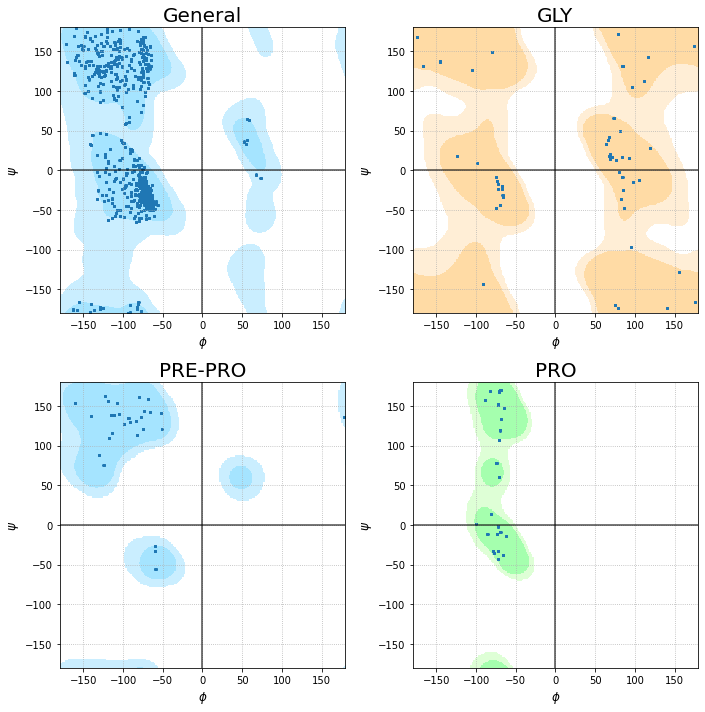

In [ ]:
plot_ramachandran(pdb_file)